*updated 03 Aug 2025, Julian Mak (whatever with copyright, do what you want with this)

### As part of material for OCES 4303 "AI and Machine Learning in Marine Science" delivered at HKUST

For the latest version of the material, go to the public facing [GitHub](https://github.com/julianmak/OCES4303_ML_ocean) page.

---
# 4. Clustering

Given unlabelled data it may be of interest to label them according to how "close" the data is to each other. ***Clustering*** is a means to do this: you group and label blocks of data samples according to some criterion related to whatever you want to mean by "closeness". 

One reason you may want to have different regression models or train regression models differently depending on the data. Piggy-backing on some previous material:

1. From the penguins example you may remember that Gentoo has somewhat different properties compared to the other two. Models trained on everything is not expected to work that well (and it doesn't). In that case it is obvious to split by `species` (because that already comes with the data), but you could imagine you got unlabelled data instead. Then you'd want to cluster first and then possibly train different models accordingly.
2. You may want to reduce dimension and ideally separate out data, then cluster, then train models accordingly. The labels also provide extra features that could be fed to the model.

> NOTE: The above points are things you should probably consider doing certainly for the first assignment relating to Argo data.

Clustering algorithms work by having some measure of "closeness", whatever you want that to mean. Going to demonstrate roughly how clustering algorithms might work and some subtleties related to the measure of "closeness".

> NOTE: This is again a problem in the choice of "metric".

> ## Key Objective(s)
> 1. Understand the rough idea and possible uses of clustering.
> 2. Note how clustering depends on the measure of distance, and how that plays with dimension reduction techniques.
> 3. Implement and explore the use of clustering for oceanic applications (see assignment also).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from sklearn.preprocessing import StandardScaler

---
## a) $K$-means clustering

A simple case for clustering that we can demonstrate reasonably easily is ***$K$-means clustering***. I am going to demonstrate how this works in 2d manually first, and the generalisation to arbitrary dimensions and use in `sklearn` should be fairly obvious.

### 0. Create some data first

Below I am going to artificially create three blobs of data (and kicked around by some noise). By eye it should be suggestive that there would be three clusters.

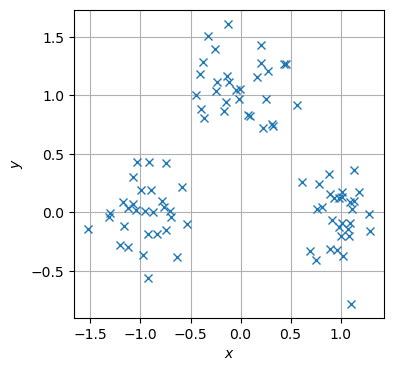

In [2]:
# create cluster centers (in a triangle in this case), then add noise to them
X = np.concat((np.ones((30, 2)) * [ 0.0, 1.0],
               np.ones((30, 2)) * [ 1.0, 0.0],
               np.ones((30, 2)) * [-1.0, 0.0]))
X += 0.25 * np.random.randn(X.shape[0], 2)  # made this small-ish so clusters show up

fig = plt.figure(figsize=(4, 4))
ax = plt.axes()
ax.plot(X[:, 0], X[:, 1], 'x')
ax.set_xlabel(r"$x$"); ax.set_ylabel(r"$y$");
ax.grid();

### 1. Specify number of clusters $K$ and location of their initial centroid

A user defined parameter (and thus a model hyper-parameter) is the number of clusters $K$ (hence $K$-means). Step 0 of plotting out the data suggests to me maybe I should choose $K = 3$, so I do that and in this case take an educated guess where the centres of the clusters (the **centroid**) are; we will consider the randomly initialised case later.

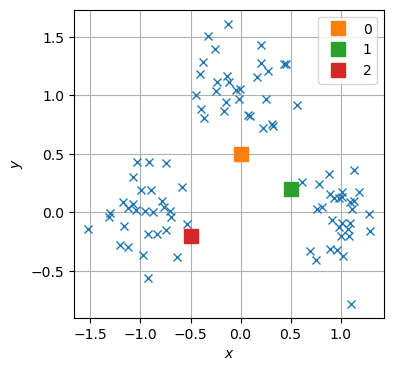

In [3]:
# initialise centroid guesses and plot where these are
centroid = np.array([[0.0, 0.5], [0.5, 0.2], [-0.5, -0.2]]) # centroid[number, coord]

fig = plt.figure(figsize=(4, 4))
ax = plt.axes()
ax.plot(X[:, 0], X[:, 1], 'x')
for i in range(centroid.shape[0]):
    ax.plot(centroid[i, 0], centroid[i, 1], 's', markersize=10, label=f"{i}")
ax.set_xlabel(r"$x$"); ax.set_ylabel(r"$y$");
ax.grid()
ax.legend();

### 2. Label the clusters according to how close they are to the centroids

This depends on the choice of distance, and the usual (but not the only) choice is to take the $L^2$ distance (sometimes called ***Euclidean distance***). Below I do just that although I ignore the square root procedure: if you had units you would need a square root to get a distance, but the magnitude ordering is exactly the same.

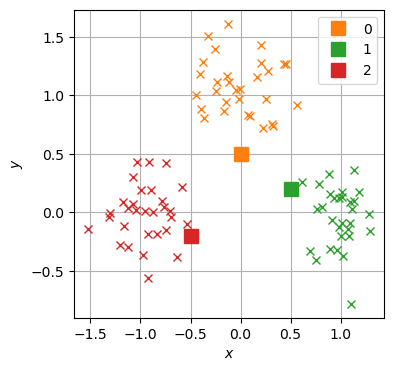

In [4]:
# iterate by computing distances and assigning labels to points closest to centroids

# L2 or root-mean-square distance (the root is not actually important here)
dist = np.sum((X - centroid[0, :]) ** 2, axis=-1)  # sum along the co-ord dimension
label = np.zeros(X.shape[0])  # set everything to belong to zero for now

for i in range(1, centroid.shape[0]):
    # compute new distance, and update baseline references as appropriate
    dist_dum = np.sum((X - centroid[i, :]) ** 2, axis=-1)
    label = np.where(dist_dum < dist, i, label)
    dist = np.where(dist_dum < dist, dist_dum, dist)

fig = plt.figure(figsize=(4, 4))
ax = plt.axes()
for i in range(centroid.shape[0]):
    ax.plot(X[label==i, 0], X[label==i, 1], f"C{i+1}x")
    ax.plot(centroid[i, 0], centroid[i, 1], f"C{i+1}s", markersize=10, label=f"{i}")
ax.set_xlabel(r"$x$"); ax.set_ylabel(r"$y$");
ax.grid()
ax.legend();

### 3. Update the centroid locations, and iterate

Give the identified clusters, find the "centres" of those. I found it below by doing an optimistion problem (find the $L^2$ minimiser), although I am thinking you could probably just take an average (although something doesn't feel right with the procedre to me...)

Then you iterate until some tolerance has been reached (e.g. the centroids don't move that much after a certain point, the classification hasn't changed after enough iterations etc.)

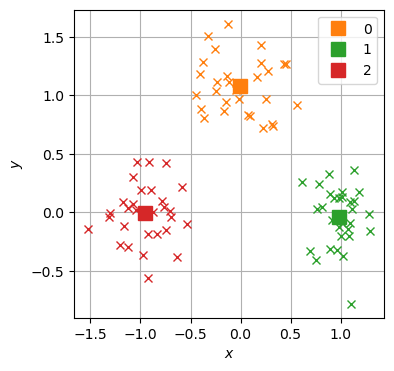

In [5]:
# compute new centroid location from classification solving an optimisation problem
from scipy.optimize import minimize

# define the cost function
def func(centroid, X):
    return np.sum((X - centroid)**2)  # want the L2 minimiser

# cycle through the data and update the centroids
for i in range(centroid.shape[0]):
    res = minimize(func, centroid[i, :], args=X[label==i, :])
    centroid[i, :] = res.x

# plot new locations
fig = plt.figure(figsize=(4, 4))
ax = plt.axes()
for i in range(centroid.shape[0]):
    ax.plot(X[label==i, 0], X[label==i, 1], f"C{i+1}x")
    ax.plot(centroid[i, 0], centroid[i, 1], f"C{i+1}s", markersize=10, label=f"{i}")
ax.set_xlabel(r"$x$"); ax.set_ylabel(r"$y$");
ax.grid()
ax.legend();

### Doing this through `sklearn`

A good exercise is to try writing your own $K$-means (mine wraps all of the above in about 30 lines of code). Failing that, we could use `sklearn`. Below code cells demonstrate the relevant syntax with the artificial data above and considers varying the initial guess via specifying `random_state`.

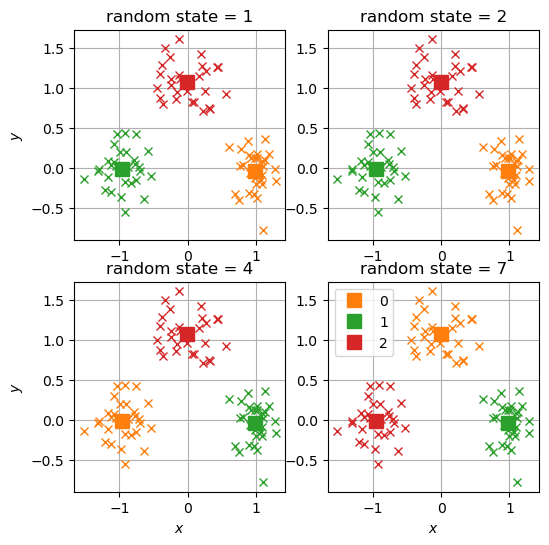

In [6]:
# load packages
from sklearn.cluster import KMeans

random_states = [1, 2, 4, 7]

fig = plt.figure(figsize=(6, 6))

for j in range(len(random_states)):
    # initialise model, fit and then return labels
    model = KMeans(n_clusters=3, random_state=random_states[j])
    model.fit(X)
    label = model.predict(X)  # could have used "model.fit_predict"
    
    ax = plt.subplot(2, 2, j+1)
    for i in range(model.n_clusters):
        ax.plot(X[label==i, 0], X[label==i, 1], f"C{i+1}x")
        ax.plot(model.cluster_centers_[i, 0], model.cluster_centers_[i, 1], f"C{i+1}s", 
                markersize=10, label=f"{i}")
    if j > 1:
        ax.set_xlabel(r"$x$")
    if j % 2 == 0:
        ax.set_ylabel(r"$y$");
        
    ax.set_title(f"random state = {random_states[j]}")
    ax.grid()

ax.legend();

The thing to note here is that the clusters themselves are fairly robust although the labels differ. That's a mild annoyance if wanting to use this to compare with already labelled data, but a relabelling with fix that if need be.

The algorithm generalises to high dimensions if you think of a piece of data as some point in some high dimensional space with co-ordinates given by each of the numbers in the features dimenison, and taking the higher dimension analogue of the $L^2$ distance.

> <span style="color:red">Q.</span> Have a think what would happen to the classification if two data points happen to have identical distances.

---
## b) Manifold methods revisited

As noted one needs to then be a bit careful about the choice of distance. In the below example I have two half moons in 2d and an swiss-roll shaped data in 3d, using a tool already in `sklearn` (and is nicer than the examples I manually tried to generate), and I am going to apply $K$-means to it as usual.

> NOTE: The `make_s_curve` one is a good choice for 3d testing too.

<img src="https://i.imgur.com/rOgacgN.png" width="450" alt='moon and swiss roll'>

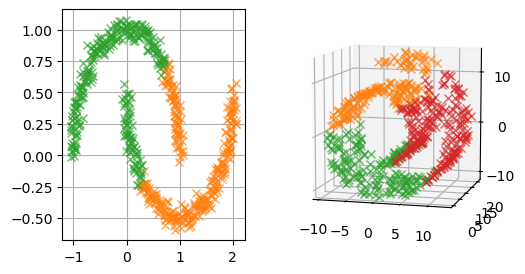

In [7]:
from sklearn.datasets import make_moons, make_swiss_roll

n_samples = 600
X_moon, _ = make_moons(n_samples, noise=0.05)     # don't need labels
X_swiss, swiss_color = make_swiss_roll(n_samples, noise=0.01)  # don't need swiss_color just yet

fig = plt.figure(figsize=(8, 3))

# moon data should have 2 clusters
ax = plt.subplot2grid((1, 3), (0, 0))
label = KMeans(n_clusters=2).fit_predict(X_moon)
for i in range(2):
    ax.plot(X_moon[label==i, 0], X_moon[label==i, 1], f"C{i+1}x", alpha=0.7)
ax.grid()

# S data is one continuous thing, 3 clusters for now
ax = plt.subplot2grid((1, 3), (0, 1), colspan=2, projection="3d")
label = KMeans(n_clusters=3, random_state=0).fit_predict(X_swiss)
for i in range(3):
    ax.plot(X_swiss[label==i, 0], 
            X_swiss[label==i, 1], 
            X_swiss[label==i, 2], f"C{i+1}x", alpha=0.7)
ax.view_init(azim=-75, elev=9)
ax.set_box_aspect((1, 1, 1))
ax.set_anchor("W");

Both of these demonstrate cases where in this case the ambient measure of distance (in this case $L^2$ in $\mathbb{R}^2$ and $\mathbb{R}^3$) is not the relevant distance: the data has a distribution that lives on some surface (which I are going to label as the ***manifold***), and it's the ***intrinsic*** measure of distance on the manifold that should be the relevant one, rather than the ***extrinsic*** one inherited from the data manifold being embedded in this case in and $\mathbb{R}^2$ and $\mathbb{R}^3$. One could argue for example that:

* The two moons are really 1d curves living in $\mathbb{R}^2$ up to noise
* The Swiss roll is really a 2d surface living in $\mathbb{R}^3$ up to noise

This is where the previous dimensional reduction techniques may be useful: you take the data and try and find a projection onto lower dimension space to pull out the key features (cf. a co-ordinate "transformation"), then in the transformed space your "distance" may actually make sense, then you do clustering on that.

Below demonstrates that with the moon data first, where we expect 2 clusters.

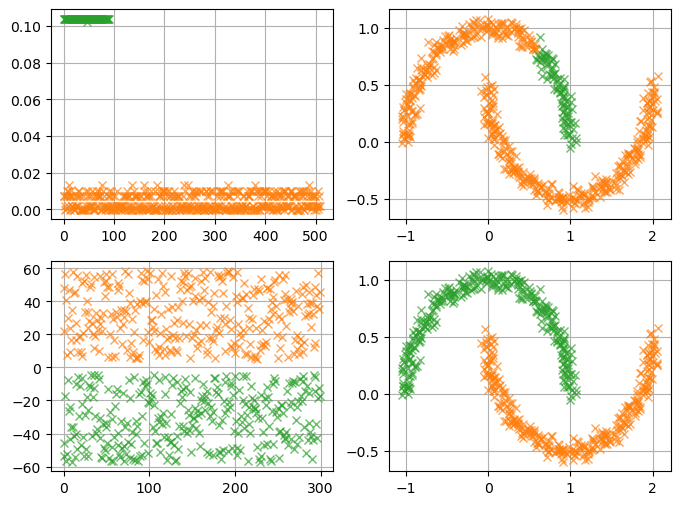

In [8]:
from sklearn.manifold import LocallyLinearEmbedding, TSNE

# find 1d projections of 2d data
lle = LocallyLinearEmbedding(n_components=1, random_state=777)
tsne = TSNE(n_components=1, random_state=777)
X_moon_lle = lle.fit_transform(X_moon)
X_moon_tsne = tsne.fit_transform(X_moon)

fig = plt.figure(figsize=(8, 6))

# predicting after LLE transformation
label = KMeans(n_clusters=2).fit_predict(X_moon_lle)
ax = plt.subplot(2, 2, 1)
for i in range(2):
    ax.plot(X_moon_lle[label==i, 0], f"C{i+1}x", alpha=0.7)
ax.grid()

ax = plt.subplot(2, 2, 2)
for i in range(2):
    ax.plot(X_moon[label==i, 0], X_moon[label==i, 1], f"C{i+1}x", alpha=0.7)
ax.grid()

# predicting after TSNE transformation
label = KMeans(n_clusters=2).fit_predict(X_moon_tsne)
ax = plt.subplot(2, 2, 3)
for i in range(2):
    ax.plot(X_moon_tsne[label==i, 0], f"C{i+1}x", alpha=0.7)
ax.grid()

ax = plt.subplot(2, 2, 4)
for i in range(2):
    ax.plot(X_moon[label==i, 0], X_moon[label==i, 1], f"C{i+1}x", alpha=0.7)
ax.grid();

So this one does actually work reasonably well as long as I do a 1d projection, rather than a 2d transformation (which I started off with for some stupid reason in hindsight). The $t$-SNE projection is more robust generally than the LLE one, at least from my empirical testing.

> <span style="color:red">Q.</span> I find that depending on the initialisation of the data (because the `random_state` is already fixed) the LLE approach is a bit brittle, while the $t$-SNE case is more robust. Consider doing an ensemble of these and test for the robustness.
> 
> <span style="color:red">Q.</span> Try a 2d co-ordinate transformation instead. You will need to modify the plotting code somewhat.

Below shows an analogous approach on swiss roll data.

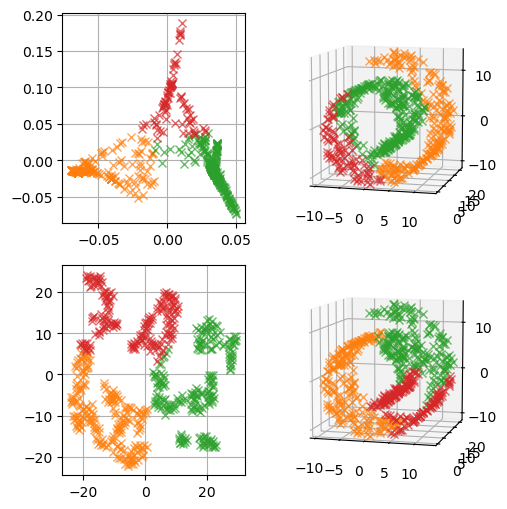

In [9]:
# find 2d projections (because original data is in 3d)

lle = LocallyLinearEmbedding(n_components=2, random_state=777)
tsne = TSNE(n_components=2, random_state=777)
X_swiss_lle = lle.fit_transform(X_swiss)
X_swiss_tsne = tsne.fit_transform(X_swiss)

fig = plt.figure(figsize=(8, 6))

# predicting after LLE transformation
label = KMeans(n_clusters=3).fit_predict(X_swiss_lle)
ax = plt.subplot2grid((2, 3), (0, 0))
for i in range(3):
    ax.plot(X_swiss_lle[label==i, 0], 
            X_swiss_lle[label==i, 1], f"C{i+1}x", alpha=0.7)
ax.grid()

ax = plt.subplot2grid((2, 3), (0, 1), colspan=2, projection="3d")
for i in range(3):
    ax.plot(X_swiss[label==i, 0], 
            X_swiss[label==i, 1], 
            X_swiss[label==i, 2], f"C{i+1}x", alpha=0.7)
ax.view_init(azim=-75, elev=9)
ax.set_box_aspect((1, 1, 1))
ax.set_anchor("W")

# predicting after LLE transformation
label = KMeans(n_clusters=3).fit_predict(X_swiss_tsne)
ax = plt.subplot2grid((2, 3), (1, 0))
for i in range(3):
    ax.plot(X_swiss_tsne[label==i, 0], 
            X_swiss_tsne[label==i, 1], f"C{i+1}x", alpha=0.7)
ax.grid()

ax = plt.subplot2grid((2, 3), (1, 1), colspan=2, projection="3d")
for i in range(3):
    ax.plot(X_swiss[label==i, 0], 
            X_swiss[label==i, 1], 
            X_swiss[label==i, 2], f"C{i+1}x", alpha=0.7)
ax.view_init(azim=-75, elev=9)
ax.set_box_aspect((1, 1, 1))
ax.set_anchor("W");

In the swiss roll case it looks like the approaches are able to find segments of the data appropriately, but this is again slightly more brittle depending on initialisations.

> <span style="color:red">Q.</span> Again, consider doing an ensemble of these and test for the robustness.

### DBSCAN

Instead of $K$-means there is an approach called `DBSCAN`, which asserts that clusters occur as high density of data points separated by gaps that are lower density. This is more a local approach and can also be flexible with the choice of metric (hence it's grouping here), although it does have potential drawbacks in that there are more model hyperparameters (`min_samples` and `eps` to give a measure what is meant by "dense"); the number of clusters that falls out is a result of those two choices (and thus we have less control on what drops out). Below shows the two demonstrations with the moons and swiss roll data in the original embedding space.

> NOTE: The black dots are **noise points** and has a label of `-1`. These are points close enough to multiple identified clusters that DBSCAN is unable to classify them.

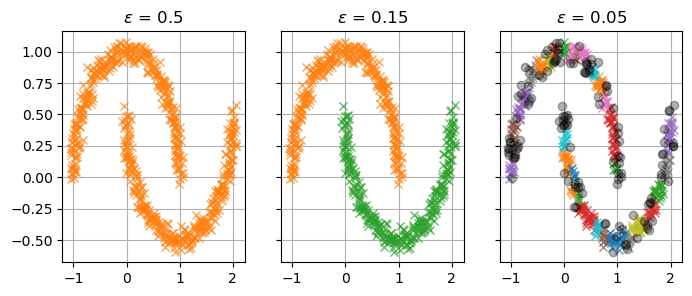

In [10]:
from sklearn.cluster import DBSCAN

# moon data
eps_vec = [0.5, 0.15, 0.05]  # keep default of min_samples = 5

fig = plt.figure(figsize=(8, 3))

# moon data should have 2 clusters
for j in range(len(eps_vec)):
    ax = plt.subplot(1, 3, j+1)
    label = DBSCAN(eps=eps_vec[j]).fit(X_moon).labels_
    # identify number of labels
    n_clusters = len(set(label)) - (1 if -1 in label else 0)
    for i in range(n_clusters):
        ax.plot(X_moon[label==i, 0], X_moon[label==i, 1], f"C{i+1}x", alpha=0.7)
    ax.plot(X_moon[label==-1, 0], X_moon[label==-1, 1], f"ko", alpha=0.3)  # noise points
    ax.grid()
    ax.set_title(f"$\epsilon$ = {eps_vec[j]}")
    if j > 0:
        ax.set_yticklabels([])

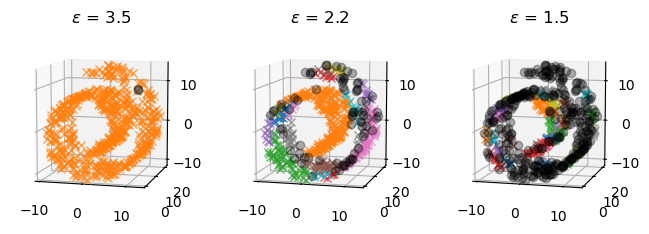

In [11]:
# swiss roll data
eps_vec = [3.5, 2.2, 1.5]  # keep default of min_samples = 5

fig = plt.figure(figsize=(8, 3))

# swiss roll data is one continuous cluster
for j in range(len(eps_vec)):
    ax = plt.subplot(1, 3, j+1, projection="3d")
    label = DBSCAN(eps=eps_vec[j]).fit(X_swiss).labels_
    # identify number of labels
    n_clusters = len(set(label)) - (1 if -1 in label else 0)

    for i in range(n_clusters):
        ax.plot(X_swiss[label==i, 0], 
                X_swiss[label==i, 1], 
                X_swiss[label==i, 2], f"C{i+1}x", alpha=0.7)
    ax.plot(X_swiss[label==-1, 0], 
            X_swiss[label==-1, 1],
            X_swiss[label==-1, 2], f"ko", alpha=0.3)  # noise points
    ax.view_init(azim=-75, elev=9)
    ax.set_box_aspect((1, 1, 1))
    ax.set_anchor("W")
    ax.set_title(f"$\epsilon$ = {eps_vec[j]}")

In the moon data if `eps` is too large then it just lumps everything together. If it's too small then there are a lot of noise points and tons of clusters. There is thus an optimum `eps` that gives the expected two.

In the swiss roll data, it really is one big cluster so in this case `eps` being large-ish is actually ok. For moderate `eps` it is identifying clusters somewhat according to the unrolling of the swiss roll so that's good. If `eps` is too small there is too much noise as before.

So cross-validation and exploration of hyperparameters with DBSCAN is important!

> <span style="color:red">Q.</span> I kept `min_samples` as the default value of 5. Explore what happens when you change that.
> 
> <span style="color:red">Q.</span> Try the above but also with appropriate dimensional reduction / co-ordinate transformation approaches.

---
## c) Demonstration: Penguins data

We are going to do brute force $K$-means on the penguins data and compare the clustered results with the species ones. Note from the previous lecture that we think the $t$-SNE can do a good job projecting the 4d data down to 2d with a good separation, so we are also going to consider including that as an intermediate step.

In [12]:
# load the data
option = "remote"

if option == "local":
    print("loading data locally (assumes file has already been downloaded)")
    path = "penguins.csv"
elif option == "remote":
    print("loading data remotely")
    path = "https://raw.githubusercontent.com/julianmak/OCES4303_ML_ocean/refs/heads/main/penguins.csv"
else:
    raise ValueError("INVALID OPTION: use 'remote' or 'local'")

df = pd.read_csv(path)

loading data remotely


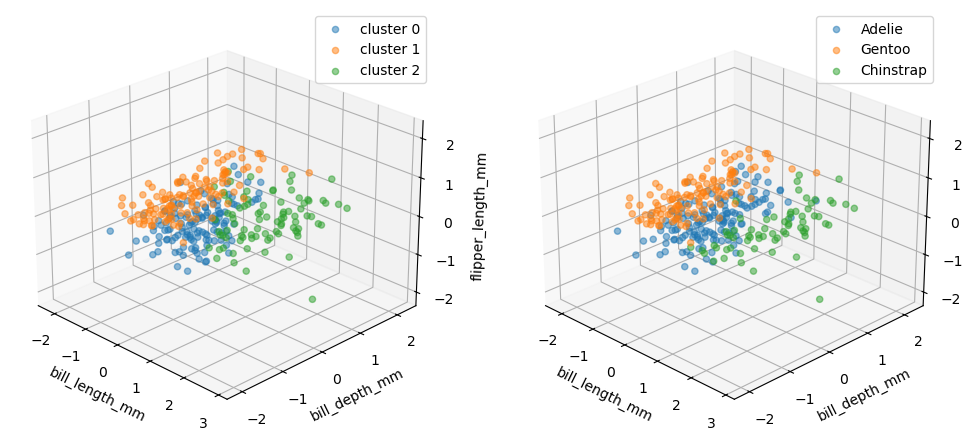

In [13]:
# pull out some data
X = df[["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]].values
Y = df["species"].values

X = StandardScaler().fit_transform(X)  # comment to switch of scaling if wanted

# instantiate model and fit with all data (no target data is needed since unsupervised)
model = KMeans(n_clusters=3, random_state=4)
Y_pred = model.fit_predict(X)

# do a 3d plot to have a look to see what is going on
key1, key2, key3 = "bill_length_mm", "bill_depth_mm", "flipper_length_mm"

fig = plt.figure(figsize=(12, 6))

# predicted clusters
ax = plt.subplot(1, 2, 1, projection="3d")
for i in range(3):
    ax.scatter(X[Y_pred==i, 0], 
               X[Y_pred==i, 1], 
               X[Y_pred==i, 2],
               label=f"cluster {i}",
               alpha=0.5)
ax.set_xlabel(f"{key1}")
ax.set_ylabel(f"{key2}")
ax.set_zlabel(f"{key3}")
ax.grid(lw=0.5, zorder=0)
ax.legend()
ax.view_init(25, -45)

# ground truth
ax = plt.subplot(1, 2, 2, projection="3d")
for species in df["species"].unique():   # pick out all unique entries under `species`
    ax.scatter(X[df["species"] == species, 0],
               X[df["species"] == species, 1],
               X[df["species"] == species, 2],
               label=species,
               alpha=0.5,  # fade this for demonstration later
               )
ax.set_xlabel(f"{key1}")
ax.set_ylabel(f"{key2}")
ax.set_zlabel(f"{key3}")
ax.grid(lw=0.5, zorder=0)
ax.legend()
ax.view_init(25, -45);

By eye there is clearly some mismatch going on if you do this brute force. To be more quantitative about it, if we think in this the colours are maching exactly (because I chose my `random_state` deliberately for this), then we can simply take `(Adelie, Gentoo, Chinstrap)` to `(0, 1, 2)`, and see how good the labels match.

In [14]:
# straight forward comparison of labels doesn't work, manually doing a remapping
Y_remap = np.zeros(Y.shape)
Y_remap[Y == "Adelie"] = 0
Y_remap[Y == "Gentoo"] = 1
Y_remap[Y == "Chinstrap"] = 2

N = len(Y_pred)
N_0, N_1, N_2 =len(Y_remap[Y_remap==0]), len(Y_remap[Y_remap==1]), len(Y_remap[Y_remap==2])
skill_all = np.sum(Y_pred == Y_remap)
skill_0   = np.sum(Y_pred[Y_remap==0] == Y_remap[Y_remap==0])
skill_1   = np.sum(Y_pred[Y_remap==1] == Y_remap[Y_remap==1])
skill_2   = np.sum(Y_pred[Y_remap==2] == Y_remap[Y_remap==2])
print(f"overall skill: {skill_all} correct out of {N} ({skill_all/N*100:.2f}%)")
print(f"    cluster 0: {skill_0} correct out of {N_0} ({skill_0/N_0*100:.2f}%)")
print(f"    cluster 1: {skill_1} correct out of {N_1} ({skill_1/N_1*100:.2f}%)")
print(f"    cluster 2: {skill_2} correct out of {N_2} ({skill_2/N_2*100:.2f}%)")
print(" ")

overall skill: 313 correct out of 342 (91.52%)
    cluster 0: 127 correct out of 151 (84.11%)
    cluster 1: 123 correct out of 123 (100.00%)
    cluster 2: 63 correct out of 68 (92.65%)
 


It's actually pretty (it wasn't when I didn't standardise the data). Doing the same but including a $t$-SNE step; for the same choice of `random_state` I need to do a slightly different label remapping here.

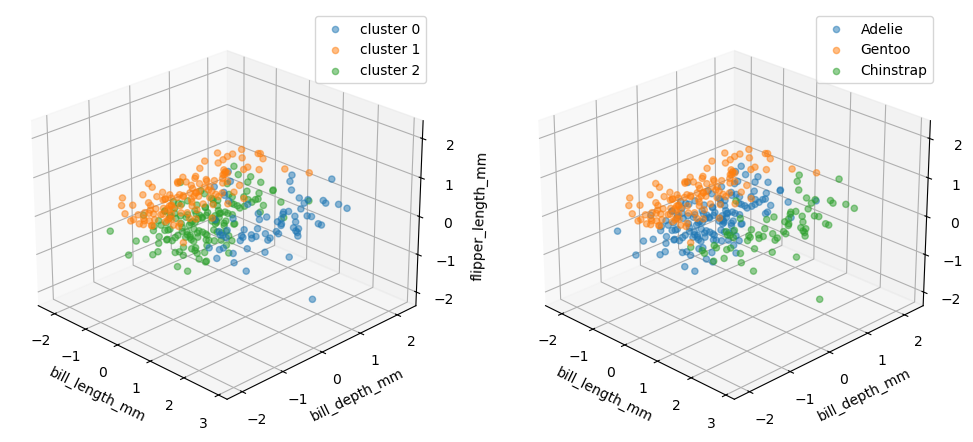

In [15]:
# as above but with a TSNE step

X = df[["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]].values
Y = df["species"].values

tsne = TSNE(random_state=4)  # default of 2 components (so 2 dimensions)
X = StandardScaler().fit_transform(X)  # comment to switch of scaling if wanted
X_tsne = tsne.fit_transform(X)

# instantiate model and fit with all data (no target data is needed since unsupervised)
model = KMeans(n_clusters=3, random_state=4)
Y_pred = model.fit_predict(X_tsne)

# do a 3d plot to have a look to see what is going on
key1, key2, key3 = "bill_length_mm", "bill_depth_mm", "flipper_length_mm"

fig = plt.figure(figsize=(12, 6))

# predicted clusters
ax = plt.subplot(1, 2, 1, projection="3d")
for i in range(3):
    ax.scatter(X[Y_pred==i, 0], 
               X[Y_pred==i, 1], 
               X[Y_pred==i, 2],
               label=f"cluster {i}",
               alpha=0.5)
ax.set_xlabel(f"{key1}")
ax.set_ylabel(f"{key2}")
ax.set_zlabel(f"{key3}")
ax.grid(lw=0.5, zorder=0)
ax.legend()
ax.view_init(25, -45)

# ground truth
ax = plt.subplot(1, 2, 2, projection="3d")
for species in df["species"].unique():   # pick out all unique entries under `species`
    ax.scatter(X[df["species"] == species, 0],
               X[df["species"] == species, 1],
               X[df["species"] == species, 2],
               label=species,
               alpha=0.5,  # fade this for demonstration later
               )
ax.set_xlabel(f"{key1}")
ax.set_ylabel(f"{key2}")
ax.set_zlabel(f"{key3}")
ax.grid(lw=0.5, zorder=0)
ax.legend()
ax.view_init(25, -45);

In [16]:
# straight forward comparison of labels doesn't work, manually doing a remapping
Y_remap = np.zeros(Y.shape)
Y_remap[Y == "Adelie"] = 2
Y_remap[Y == "Gentoo"] = 1
Y_remap[Y == "Chinstrap"] = 0

N = len(Y_pred)
N_0, N_1, N_2 =len(Y_remap[Y_remap==0]), len(Y_remap[Y_remap==1]), len(Y_remap[Y_remap==2])
skill_all = np.sum(Y_pred == Y_remap)
skill_0   = np.sum(Y_pred[Y_remap==0] == Y_remap[Y_remap==0])
skill_1   = np.sum(Y_pred[Y_remap==1] == Y_remap[Y_remap==1])
skill_2   = np.sum(Y_pred[Y_remap==2] == Y_remap[Y_remap==2])
print(f"overall skill: {skill_all} correct out of {N} ({skill_all/N*100:.2f}%)")
print(f"    cluster 0: {skill_0} correct out of {N_0} ({skill_0/N_0*100:.2f}%)")
print(f"    cluster 1: {skill_1} correct out of {N_1} ({skill_1/N_1*100:.2f}%)")
print(f"    cluster 2: {skill_2} correct out of {N_2} ({skill_2/N_2*100:.2f}%)")
print(" ")

overall skill: 329 correct out of 342 (96.20%)
    cluster 0: 63 correct out of 68 (92.65%)
    cluster 1: 123 correct out of 123 (100.00%)
    cluster 2: 143 correct out of 151 (94.70%)
 


This provides a mild increase in the clustering skill, which is nice to see.

> <span style="color:red">Q.</span> Explore what happens if I don't standardise. Why and where do you think the problem is? (The former you should know, the latter you might need to think a litte bit.)
> 
> <span style="color:red">Q.</span> I didn't do `train_test_split`, but consider what happens if I do that, and see how good the label predictions are.
> 
> <span style="color:red">Q.</span> Do an ensemble of these and see how robust the scores are.
> 
> <span style="color:red">Q.</span> Explore above but with different hyperparameters, and evaluate the sensitivity of scores to hyperparameters.

----------------
# More involved exercises with this notebook

## 1) Other clustering algorithms

There are a whole load of them at the [clustering](https://scikit-learn.org/stable/modules/clustering.html) page of `sklearn`. Have a look at them and see what you make of them, particularly of Gaussian Mixture Models (GMM), which I reference in the lecture but don't actually use it.

(You can also explore the other [manifold learning](https://scikit-learn.org/stable/modules/manifold.html) methods.)

## 2) Primer for the assignment: using labels to improve models for `penguins`

Use the identified clusters to train different linear models, or add the cluster labels in as an extra feature to train linear models. This is something you should do for the assignment with Argo data.

## 3) Clustering and/or manifold learning of cats (possibly also data cleaning)

(May be useful for dealing with the penguins/turtle dataset and in classification tasks.)

Consider applying clustering and/or manifold learning to cat images: this is a bit like what is done for the [digits dataset](https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html), but larger dimension. I would start with the smaller `cats.csv` dataset first to see if you can identify clusters of data.

If you are feeling brave and/or have some computational resources lying around, consider using the larger `cat_bw_enlarged.csv` dataset, and possibly use these approaches to detect ***outliers*** (there are definitely outliers or "not good" images in the dataset). This may be one way to use machine learning to help clean data, then feed the cleaner dataset back in for machine learning.